In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from IPython.display import Image
pd.set_option('display.max_columns', 125)
pd.set_option('display.max_rows', 125)

#module to retrieve weather data
!pip install meteostat
from meteostat import Point, Daily

# **Weather and Power Outage Data**

**We are given two distinct data sets: weather data for a particular area in Pennsylvania and power outages in Pennsylvania. The data sets do not contain any overlapping columns. Our task is to find the closest power station to where the power outages occurred. This is useful to us as data scientists because once combined we can analyze what type of weather conditions can potentially cause power outages: temperature, wind speed, snowfall, rainfall, etc.**

#**Load in the Data**

In [2]:
#read in the data
df_weather = pd.read_csv('/content/weather.csv')

#check for null values
print(df_weather.isnull().sum())

WEATHER_HOURLY_PK               0
WEATHER_RECORD_TYPE             0
WEATHER_FORECAST_INTERVAL       0
METAR_ID                        0
GEOGRAPHY_FK                    0
TIME_GMT                        0
TIME_GMT_FK                     0
HOUR_OF_DAY_ID                  0
LATITUDE                        0
LONGITUDE                       0
AIR_TEMPERATURE_F               0
AIR_TEMPERATURE_FEELS_LIKE_F    0
DEWPOINT_TEMPERATURE_F          0
RELATIVE_HUMIDITY               0
WIND_SPEED_MPH                  0
WIND_GUST_MPH                   0
WIND_DIRECTION_DEG              0
CLOUD_AMOUNT                    0
PRECIPITATION_PAST_1HOUR_IN     0
SNOWFALL_PAST_1HOUR_IN          0
ATMOSPHERIC_PRESSURE_MB         0
DIRECT_NORMAL_RADIATION         0
DIFFUSE_HOZ_RADIATION           0
DOWNWARD_SOLAR_RADIATION        0
LEAF_COVERAGE                   0
INSERT_DT                       0
UPDATE_DT                       0
dtype: int64


In [3]:
#view weather data
df_weather.head()

WEATHER_HOURLY_PK WEATHER_RECORD_TYPE WEATHER_FORECAST_INTERVAL METAR_ID  \
0            3747990               METAR                    HOURLY     KMUI   
1            3747991               METAR                    HOURLY     KMUI   
2            3747992               METAR                    HOURLY     KMUI   
3            3747993               METAR                    HOURLY     KMUI   
4            3747994               METAR                    HOURLY     KMUI   

   GEOGRAPHY_FK   TIME_GMT  TIME_GMT_FK  HOUR_OF_DAY_ID  LATITUDE  LONGITUDE  \
0             1  12-Jan-15     20150112              11     40.43     -76.57   
1             1  12-Jan-15     20150112              12     40.43     -76.57   
2             1  12-Jan-15     20150112              13     40.43     -76.57   
3             1  12-Jan-15     20150112              14     40.43     -76.57   
4             1  12-Jan-15     20150112              15     40.43     -76.57   

   AIR_TEMPERATURE_F  AIR_TEMPERATURE_FEELS_LIKE_F  DEWPOINT_TEMPERATURE_F  \
0               31.6                          31.6                    30.9   
1               32.0                          32.0                    31.3   
2               32.0                          32.0                    32.0   
3               32.9                          29.8                    31.6   
4               33.1                          33.1                    31.8   

   RELATIVE_HUMIDITY  WIND_SPEED_MPH  WIND_GUST_MPH  WIND_DIRECTION_DEG  \
0                 97             0.0            2.7                   0   
1                 97             0.0            2.2                   0   
2                100             0.0            2.7                   0   
3                 95             3.4            6.0                 230   
4                 95             0.0            3.1                   0   

   CLOUD_AMOUNT  PRECIPITATION_PAST_1HOUR_IN  SNOWFALL_PAST_1HOUR_IN  \
0           100                         0.10                     0.0   
1           100                         0.03                     0.0   
2            90                         0.01                     0.0   
3           100                         0.00                     0.0   
4            60                         0.00                     0.0   

   ATMOSPHERIC_PRESSURE_MB  DIRECT_NORMAL_RADIATION  DIFFUSE_HOZ_RADIATION  \
0                   1024.9                        0                     49   
1                   1023.8                        0                     84   
2                   1022.6                        0                    116   
3                   1021.5                        0                    142   
4                   1021.5                       32                    137   

   DOWNWARD_SOLAR_RADIATION LEAF_COVERAGE INSERT_DT UPDATE_DT  
0                        49   NO COVERAGE  5-Dec-16  5-Dec-16  
1                        84   NO COVERAGE  5-Dec-16  5-Dec-16  
2                       116   NO COVERAGE  5-Dec-16  5-Dec-16  
3                       142   NO COVERAGE  5-Dec-16  5-Dec-16  
4                       148   NO COVERAGE  5-Dec-16  5-Dec-16

In [4]:
#read in the data
df_power_data= pd.read_csv('/content/outages.csv')

#filter down to just the power outage incidents
print(df_power_data['INCIDENT_STATUS'].unique())
df_outage = df_power_data[df_power_data['INCIDENT_STATUS'] != 'No Outage']

['Restored' 'No Outage' 'Partially Restored']


In [5]:
#check for null values
print(df_outage.isnull().sum())

OUTAGE_PK                            0
ORDER_ID                             0
INCIDENT_ID                          0
JOB_NUMBER                           0
OUTAGE_TYPE                          0
INCIDENT_STATUS                      0
GRID_NUMBER                          0
GRID_POLT_AREA_FK                    0
TROUBLE_TIME                         0
TROUBLE_TIME_FK                      0
TROUBLE_TIME_CLOCK_FK                0
TROUBLE_YR_MONTH                     0
LOCATION_DESC                        0
CREATION_TIME                        0
CREATION_TIME_CLOCK_FK               0
ASSIGNED_TIME                     1916
RESTORED_TIME                        0
RESTORED_TIME_FK                     0
RESTORED_TIME_CLOCK_FK               0
CLOSURE_TIME                         0
CLOSURE_TIME_FK                      0
CLOSURE_TIME_CLOCK_FK                0
PRIORITY                             1
MIN_X                             1484
MIN_Y                             1484
MAX_X                    

In [6]:
df_outage.head()

OUTAGE_PK  ORDER_ID  INCIDENT_ID JOB_NUMBER OUTAGE_TYPE INCIDENT_STATUS  \
0     1219519   3903568      3996610  4002534-1          NL        Restored   
3     1219740   3903061      3996049  4002027-1          NL        Restored   
7     1219815   3903263      3996399  4002229-1          NL        Restored   
8     1215540   3898578      3991440  3997543-1          NL        Restored   
11    1215617   3898626      3991503  3997591-1          NL        Restored   

    GRID_NUMBER  GRID_POLT_AREA_FK TROUBLE_TIME  TROUBLE_TIME_FK  \
0   12480S38159            7893233     9-Oct-17         20171009   
3   24368S32675            7163075     9-Oct-17         20171009   
7   60953S50907            6706782     9-Oct-17         20171009   
8   61462N26393            6911857    28-Sep-17         20170928   
11  63570S44243            6742719    28-Sep-17         20170928   

    TROUBLE_TIME_CLOCK_FK TROUBLE_YR_MONTH  \
0                   57459          2017-10   
3                   36821          2017-10   
7                   42901          2017-10   
8                   36449          2017-09   
11                  42222          2017-09   

                            LOCATION_DESC CREATION_TIME  \
0            12480S38159 - GREEN PARK SUB      9-Oct-17   
3                             24368S32675      9-Oct-17   
7     60953S50907 - NEFF-LAURYS RD-E T706      9-Oct-17   
8          61462N26393 - S OF TRACHSVILLE     28-Sep-17   
11  63570S44243 - KOZY KOR LA W LIMEPT PK     28-Sep-17   

    CREATION_TIME_CLOCK_FK ASSIGNED_TIME RESTORED_TIME  RESTORED_TIME_FK  \
0                    57459           NaN      9-Oct-17          20171009   
3                    37167      9-Oct-17      9-Oct-17          20171009   
7                    42904      9-Oct-17      9-Oct-17          20171009   
8                    36451     28-Sep-17     28-Sep-17          20170928   
11                   42226     28-Sep-17     28-Sep-17          20170928   

    RESTORED_TIME_CLOCK_FK CLOSURE_TIME  CLOSURE_TIME_FK  \
0                    57459    10-Oct-17         20171010   
3                    49020     9-Oct-17         20171009   
7                    52140     9-Oct-17         20171009   
8                    42600    28-Sep-17         20170928   
11                   50400     6-Oct-17         20171006   

    CLOSURE_TIME_CLOCK_FK  PRIORITY        MIN_X        MIN_Y        MAX_X  \
0                   29820       4.0          NaN          NaN          NaN   
3                   49560       3.0  683875566.0   99595146.0  683875566.0   
7                   52200       3.0  795386836.0  155014818.0  795596376.0   
8                   46020       3.0  795462670.0  171196294.0  796924364.0   
11                  29940       3.0  803375626.0  134578949.0  803923196.0   

          MAX_Y  SIMPLE_AREA_ID  OUTAGE_AREA_FK CAUSE_CODE  \
0           NaN         1478903           10231         ??   
3    99595146.0         1478900           10228         60   
7   155206644.0         1478880           10208         30   
8   172899092.0         1478891           10219         35   
11  134844704.0         1478880           10208         60   

                         CAUSE SUBCAUSE_CODE      SUBCAUSE WCF  \
0                      Unknown             ?       Unknown   N   
3           Equipment Failures             4          Rain   Y   
7       Trees-Trimming Related             4          Rain   Y   
8   Trees-Not Trimming Related             6  Not a Factor   N   
11          Equipment Failures             6  Not a Factor   N   

    FAILED_FACILITY_ID FACILITY_TYPE_DESC  \
0                  NaN            Breaker   
3             944361.0        Transformer   
7             944501.0               Fuse   
8             941088.0               Fuse   
11            941122.0               Fuse   

                              FACILITY_SUBTYPE_DESC COMPONENT_ASSET_TYPE  \
0          Circuit Breaker : Oil , Gas, Vacuum, Air         Transmission   
3   Tran

In [7]:
#check the shape of the data
print(f'Shape of the weather data: {df_weather.shape}\nShape of the outage data: {df_outage.shape}')

Shape of the weather data: (10000, 27)
Shape of the outage data: (5141, 75)


# **Differing points in time between data sets**

In [8]:
df_weather.sort_values('TIME_GMT')

WEATHER_HOURLY_PK WEATHER_RECORD_TYPE WEATHER_FORECAST_INTERVAL  \
5723            3760284               METAR                    HOURLY   
5722            3760283               METAR                    HOURLY   
5721            3760282               METAR                    HOURLY   
5720            3760281               METAR                    HOURLY   
5719            3760280               METAR                    HOURLY   
...                 ...                 ...                       ...   
3494            3753313               METAR                    HOURLY   
3495            3753314               METAR                    HOURLY   
3496            3753315               METAR                    HOURLY   
3487            3753306               METAR                    HOURLY   
3482            3753301               METAR                    HOURLY   

     METAR_ID  GEOGRAPHY_FK  TIME_GMT  TIME_GMT_FK  HOUR_OF_DAY_ID  LATITUDE  \
5723     KMUI             1  1-Apr-15     20150401              19     40.43   
5722     KMUI             1  1-Apr-15     20150401              18     40.43   
5721     KMUI             1  1-Apr-15     20150401              17     40.43   
5720     KMUI             1  1-Apr-15     20150401              16     40.43   
5719     KMUI             1  1-Apr-15     20150401              15     40.43   
...       ...           ...       ...          ...             ...       ...   
3494     KMUI             1  9-Sep-14     20140909              15     40.43   
3495     KMUI             1  9-Sep-14     20140909              16     40.43   
3496     KMUI             1  9-Sep-14     20140909              17     40.43   
3487     KMUI             1  9-Sep-14     20140909               8     40.43   
3482     KMUI             1  9-Sep-14     20140909               3     40.43   

      LONGITUDE  AIR_TEMPERATURE_F  AIR_TEMPERATURE_FEELS_LIKE_F  \
5723     -76.57               50.2                          50.2   
5722     -76.57               52.2                          52.2   
5721     -76.57               52.5                          52.5   
5720     -76.57               52.0                          52.0   
5719     -76.57               51.6                          51.6   
...         ...                ...                           ...   
3494     -76.57               71.6                          71.6   
3495     -76.57               72.5                          72.5   
3496     -76.57               71.6                          71.6   
3487     -76.57               63.3                          63.3   
3482     -76.57               62.8                          62.8   

      DEWPOINT_TEMPERATURE_F  RELATIVE_HUMIDITY  WIND_SPEED_MPH  \
5723                    27.3                 41            10.3   
5722                    26.6                 37             9.2   
5721                    25.0                 34             9.2   
5720                    21.6                 30            10.3   
5719                    21.2                 30            13.9   
...                      ...                ...             ...   
3494                    61.0                 69             8.1   
3495                    61.3                 68             6.9   
3496                    61.7                 71             6.9   
3487                    58.1                 83             4.7   
3482                    59.5                 89             4.7   

      WIND_GUST_MPH  WIND_DIRECTION_DEG  CLOUD_AMOUNT  \
5723           20.4                 310            10   
5722           24.6                 310            15   
5721           27.5                 300            15   
5720           20.8                 330             0   
5719           19.5                 310             0   
...             ...                 ...           ...   
3494           14.3                 110            85   
3495           12.8                  80            75   
3496           11.9              

In [9]:
df_outage.sort_values('TROUBLE_TIME')

OUTAGE_PK  ORDER_ID  INCIDENT_ID JOB_NUMBER OUTAGE_TYPE INCIDENT_STATUS  \
9409     842908   1247930      1325767  1346895-1          NL        Restored   
7302    1193464   3806183      3897946  3905149-1          NL        Restored   
5547    1193330   3806070      3897831  3905036-1          NL        Restored   
5548    1193331   3806107      3897869  3905073-1          NL        Restored   
5549    1193332   3806136      3897899  3905102-1          NL        Restored   
...         ...       ...          ...        ...         ...             ...   
4860    1210152   3892447      3985181  3991412-1          NL        Restored   
3370    1210180   3892557      3985294  3991522-1          NL        Restored   
3369    1210108   3892546      3985283  3991511-1          NL        Restored   
2954    1210167   3892528      3985264  3991493-1          NL        Restored   
3647    1210117   3892398      3985127  3991363-1          NL        Restored   

      GRID_NUMBER  GRID_POLT_AREA_FK TROUBLE_TIME  TROUBLE_TIME_FK  \
9409  27014S36564            7771132     1-Aug-14         20140801   
7302  12227S30931            7111735     1-Aug-17         20170801   
5547  25671N34077            7015798     1-Aug-17         20170801   
5548  32110N29370            7320551     1-Aug-17         20170801   
5549  26817N37513            7690522     1-Aug-17         20170801   
...           ...                ...          ...              ...   
4860  40427S30027            7224886     9-Sep-17         20170909   
3370  39582S25876            7217766     9-Sep-17         20170909   
3369  48939S37875            7271470     9-Sep-17         20170909   
2954  71255N44833            6948507     9-Sep-17         20170909   
3647  26906S36153            7180205     9-Sep-17         20170909   

      TROUBLE_TIME_CLOCK_FK TROUBLE_YR_MONTH  \
9409                  53976          2014-08   
7302                  45981          2017-08   
5547                  35492          2017-08   
5548                  38374          2017-08   
5549                  40781          2017-08   
...                     ...              ...   
4860                  32360          2017-09   
3370                  60489          2017-09   
3369                  58260          2017-09   
2954                  53294          2017-09   
3647                   1207          2017-09   

                               LOCATION_DESC CREATION_TIME  \
9409                             27014S36564      1-Aug-14   
7302                             12227S30931      1-Aug-17   
5547                             25671N34077      1-Aug-17   
5548                             32110N29370      1-Aug-17   
5549                             26817N37513      1-Aug-17   
...                                      ...           ...   
4860        40427S30027 - E off Middlesex Rd      9-Sep-17   
3370                             39582S25876      9-Sep-17   
3369  48939S37875 - FUS TP W OFF VAN REED RD      9-Sep-17   
2954                             71255N44833      9-Sep-17   
3647                             26906S36153      9-Sep-17   

      CREATION_TIME_CLOCK_FK ASSIGNED_TIME RESTORED_TIME  RESTORED_TIME_FK  \
9409                   53979      1-Aug-14      1-Aug-14          20140801   
7302                   45983      1-Aug-17      1-Aug-17          20170801   
5547                   35493      1-Aug-17      1-Aug-17          20170801   
5548                   38374      1-Aug-17      1-Aug-17          20170801   
5549                   40782      1-Aug-17      1-Aug-17          20170801   
...                      ...           ...           ...               ...   
4860                   34801      9-Sep-17      9-Sep-17          20170909   
3370                   60851      9-Sep-17      9-Sep-17          20170909   
3369                   58265      9-Sep-17      9-Sep-17          20170909   
2954                   53296      9-Sep-17      9-Sep-17          20170909   
3647        

# **Filter down to the distinct weather stations and longitude/latitude positions**

In [10]:
#find the distinct stations
df_weather_distinct = df_weather.drop_duplicates('METAR_ID')[['METAR_ID','LATITUDE','LONGITUDE']]
df_weather_distinct

METAR_ID   LATITUDE  LONGITUDE
0        KMUI  40.430000 -76.570000
636      KMSV  41.700001 -74.800003
1380     KMQS  39.980000 -75.870003
7308     KPTW  40.250000 -75.559998

#**Create an additonal column for Latitude and Longitude**

In [11]:
#save latitude and longitude into a tuple since tuples take up less memory than a list
df_outage['LATITUDE & LONGITUDE'] = [(lat,lon) for lat,lon in zip(df_outage['LATITUDE'].astype(float), df_outage['LONGITUDE'].astype(float))]
df_weather_distinct['LATITUDE & LONGITUDE'] = [(lat,lon) for lat,lon in zip(df_weather_distinct['LATITUDE'], df_weather_distinct['LONGITUDE'])]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **Compare the distances between the columns and save the station ID to the outage DataFrame**

## **Euclidean Distance between 2 Points**

$d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2}$

### **Euclidean Distance calculation for Latitude and Longitude**

**KMUI Power Station Location: 40.43 Latitude $(q_1)$, -76.57 Longitude $(q_2)$**

**Weather Recording Location: 40.37998938 Latitude $(p_1)$, -77.30204431 Longitude $(p_2)$**

<br/>

$\text{Euclidean Distance between the two points}: \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2} =$

$\sqrt{(40.43 - 40.37998938)^2 + (-76.57 - (-77.30204431))^2} = \sqrt{(0.05001)^2 + (0.73204)^2}=$

$\sqrt{0.002501 + 0.5358889} = 0.7337$

<sup>Source: [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) from Wikipedia.org<sup/>

In [12]:
#create empty list to store the closest power stations to store the closest station to the place where the weather was measured
weather_stations = []

for loc_station in df_outage['LATITUDE & LONGITUDE']:
  #station list will store the 4 METAR stations per weather location
  station_list = []
  for station,loc_outage in zip(df_weather_distinct['METAR_ID'],df_weather_distinct['LATITUDE & LONGITUDE']):
    station_list.append([station,distance.euclidean(loc_station,loc_outage)])
  #use list comprehension to return the closest power station to where the weather was measured
  weather_stations.append([station for station in station_list if station[1] == min([el[1] for el in station_list])][0][0])
  
df_outage['METAR_ID'] = weather_stations

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
df_outage.head()

OUTAGE_PK  ORDER_ID  INCIDENT_ID JOB_NUMBER OUTAGE_TYPE INCIDENT_STATUS  \
0     1219519   3903568      3996610  4002534-1          NL        Restored   
3     1219740   3903061      3996049  4002027-1          NL        Restored   
7     1219815   3903263      3996399  4002229-1          NL        Restored   
8     1215540   3898578      3991440  3997543-1          NL        Restored   
11    1215617   3898626      3991503  3997591-1          NL        Restored   

    GRID_NUMBER  GRID_POLT_AREA_FK TROUBLE_TIME  TROUBLE_TIME_FK  \
0   12480S38159            7893233     9-Oct-17         20171009   
3   24368S32675            7163075     9-Oct-17         20171009   
7   60953S50907            6706782     9-Oct-17         20171009   
8   61462N26393            6911857    28-Sep-17         20170928   
11  63570S44243            6742719    28-Sep-17         20170928   

    TROUBLE_TIME_CLOCK_FK TROUBLE_YR_MONTH  \
0                   57459          2017-10   
3                   36821          2017-10   
7                   42901          2017-10   
8                   36449          2017-09   
11                  42222          2017-09   

                            LOCATION_DESC CREATION_TIME  \
0            12480S38159 - GREEN PARK SUB      9-Oct-17   
3                             24368S32675      9-Oct-17   
7     60953S50907 - NEFF-LAURYS RD-E T706      9-Oct-17   
8          61462N26393 - S OF TRACHSVILLE     28-Sep-17   
11  63570S44243 - KOZY KOR LA W LIMEPT PK     28-Sep-17   

    CREATION_TIME_CLOCK_FK ASSIGNED_TIME RESTORED_TIME  RESTORED_TIME_FK  \
0                    57459           NaN      9-Oct-17          20171009   
3                    37167      9-Oct-17      9-Oct-17          20171009   
7                    42904      9-Oct-17      9-Oct-17          20171009   
8                    36451     28-Sep-17     28-Sep-17          20170928   
11                   42226     28-Sep-17     28-Sep-17          20170928   

    RESTORED_TIME_CLOCK_FK CLOSURE_TIME  CLOSURE_TIME_FK  \
0                    57459    10-Oct-17         20171010   
3                    49020     9-Oct-17         20171009   
7                    52140     9-Oct-17         20171009   
8                    42600    28-Sep-17         20170928   
11                   50400     6-Oct-17         20171006   

    CLOSURE_TIME_CLOCK_FK  PRIORITY        MIN_X        MIN_Y        MAX_X  \
0                   29820       4.0          NaN          NaN          NaN   
3                   49560       3.0  683875566.0   99595146.0  683875566.0   
7                   52200       3.0  795386836.0  155014818.0  795596376.0   
8                   46020       3.0  795462670.0  171196294.0  796924364.0   
11                  29940       3.0  803375626.0  134578949.0  803923196.0   

          MAX_Y  SIMPLE_AREA_ID  OUTAGE_AREA_FK CAUSE_CODE  \
0           NaN         1478903           10231         ??   
3    99595146.0         1478900           10228         60   
7   155206644.0         1478880           10208         30   
8   172899092.0         1478891           10219         35   
11  134844704.0         1478880           10208         60   

                         CAUSE SUBCAUSE_CODE      SUBCAUSE WCF  \
0                      Unknown             ?       Unknown   N   
3           Equipment Failures             4          Rain   Y   
7       Trees-Trimming Related             4          Rain   Y   
8   Trees-Not Trimming Related             6  Not a Factor   N   
11          Equipment Failures             6  Not a Factor   N   

    FAILED_FACILITY_ID FACILITY_TYPE_DESC  \
0                  NaN            Breaker   
3             944361.0        Transformer   
7             944501.0               Fuse   
8             941088.0               Fuse   
11            941122.0               Fuse   

                              FACILITY_SUBTYPE_DESC COMPONENT_ASSET_TYPE  \
0          Circuit Breaker : Oil , Gas, Vacuum, Air         Transmission   
3   Tran

In [14]:
#check a few of the rows to make sure the calculation is correct
df_out_sample = df_outage[:5]['LATITUDE & LONGITUDE']

for location in df_out_sample:
  for station_loc,station,iter in zip(df_weather_distinct['LATITUDE & LONGITUDE'],df_weather_distinct['METAR_ID'],range(1,5)):
    print(f'Iteration: {iter}',distance.euclidean(location,station_loc),station)    

Iteration: 1 0.7337505938097562 KMUI
Iteration: 2 2.8288940230912725 KMSV
Iteration: 3 1.4868536638349144 KMQS
Iteration: 4 1.7468894026518742 KPTW
Iteration: 1 0.36829352980047125 KMUI
Iteration: 2 2.546542330505474 KMSV
Iteration: 3 1.037145060383553 KMQS
Iteration: 4 1.3175065550170182 KPTW
Iteration: 1 1.0565651071911804 KMUI
Iteration: 2 1.2427708064727654 KMSV
Iteration: 3 0.7965402410045803 KMQS
Iteration: 4 0.46004395479142374 KPTW
Iteration: 1 1.1312466647016968 KMUI
Iteration: 2 1.1041898516273445 KMSV
Iteration: 3 0.9530610137265937 KMQS
Iteration: 4 0.6202722310009218 KPTW
Iteration: 1 1.1110312235050268 KMUI
Iteration: 2 1.3489391507792343 KMSV
Iteration: 3 0.6803837764422255 KMQS
Iteration: 4 0.2918404181248329 KPTW


# **Checking our Calculation against Google Maps**

## **KMUI Power Station (Closest station)**

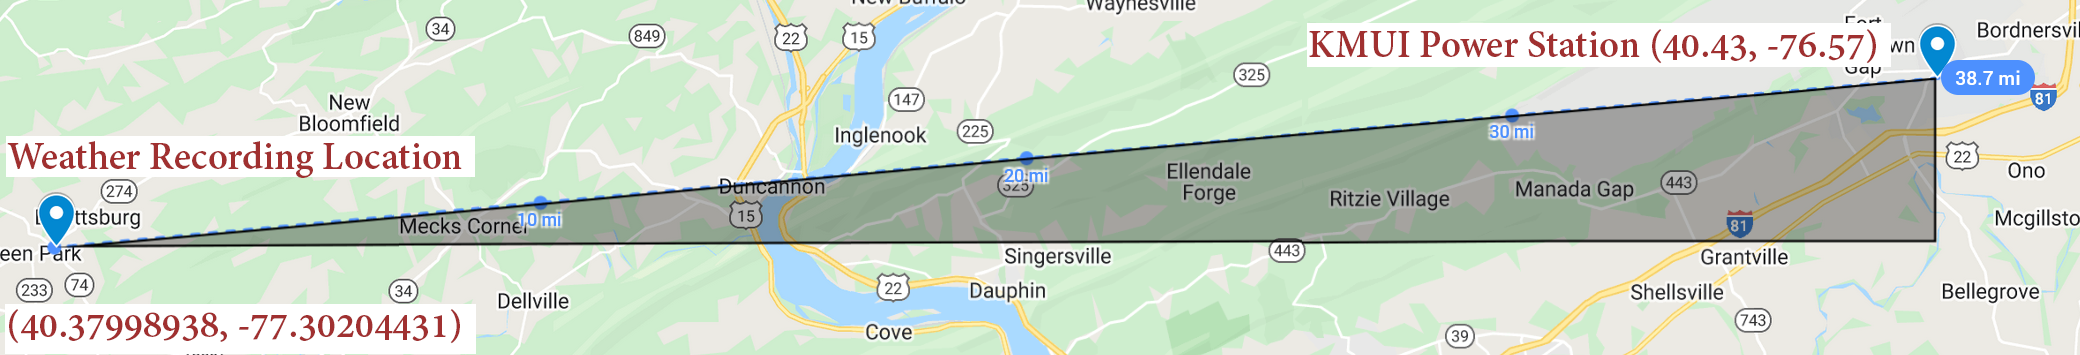

In [15]:
Image('/content/google_kmui.PNG.png')

## **KMSV Power Station (Furthest station)**

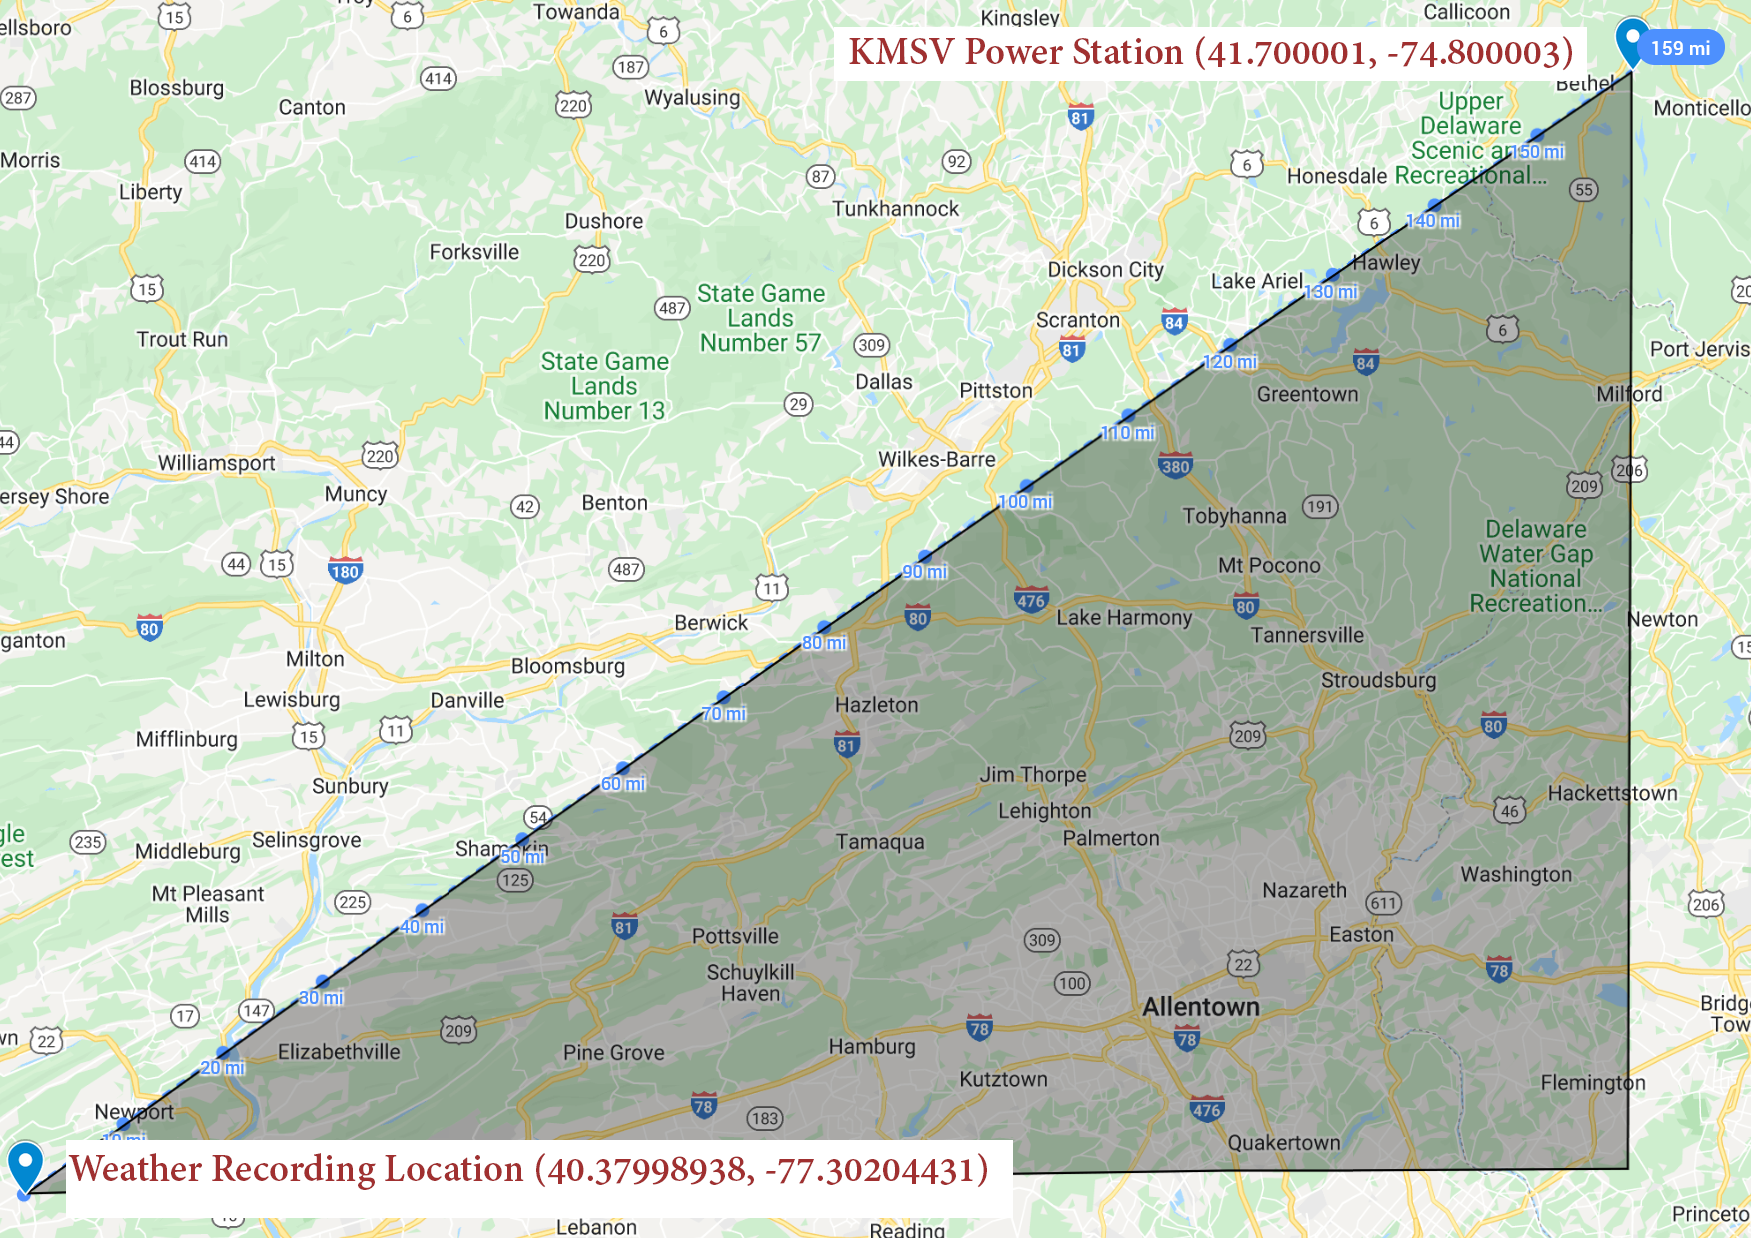

In [16]:
Image('/content/google_KMSV.PNG.png')

## **KMQS Power Station**

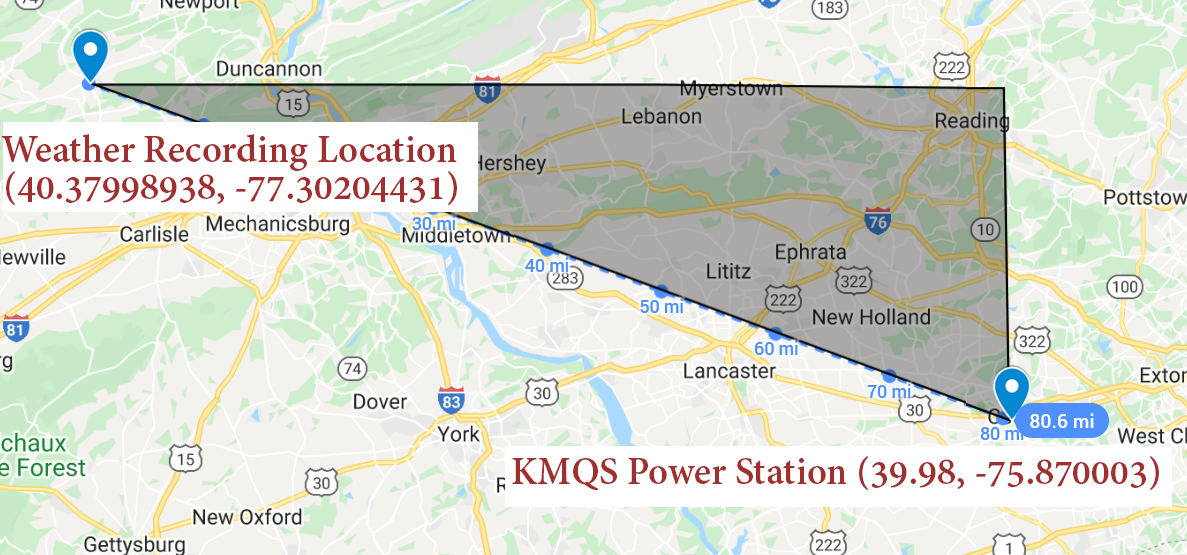

In [17]:
Image('/content/google_kmqs.PNG.png')

## **KPTW Power Station**

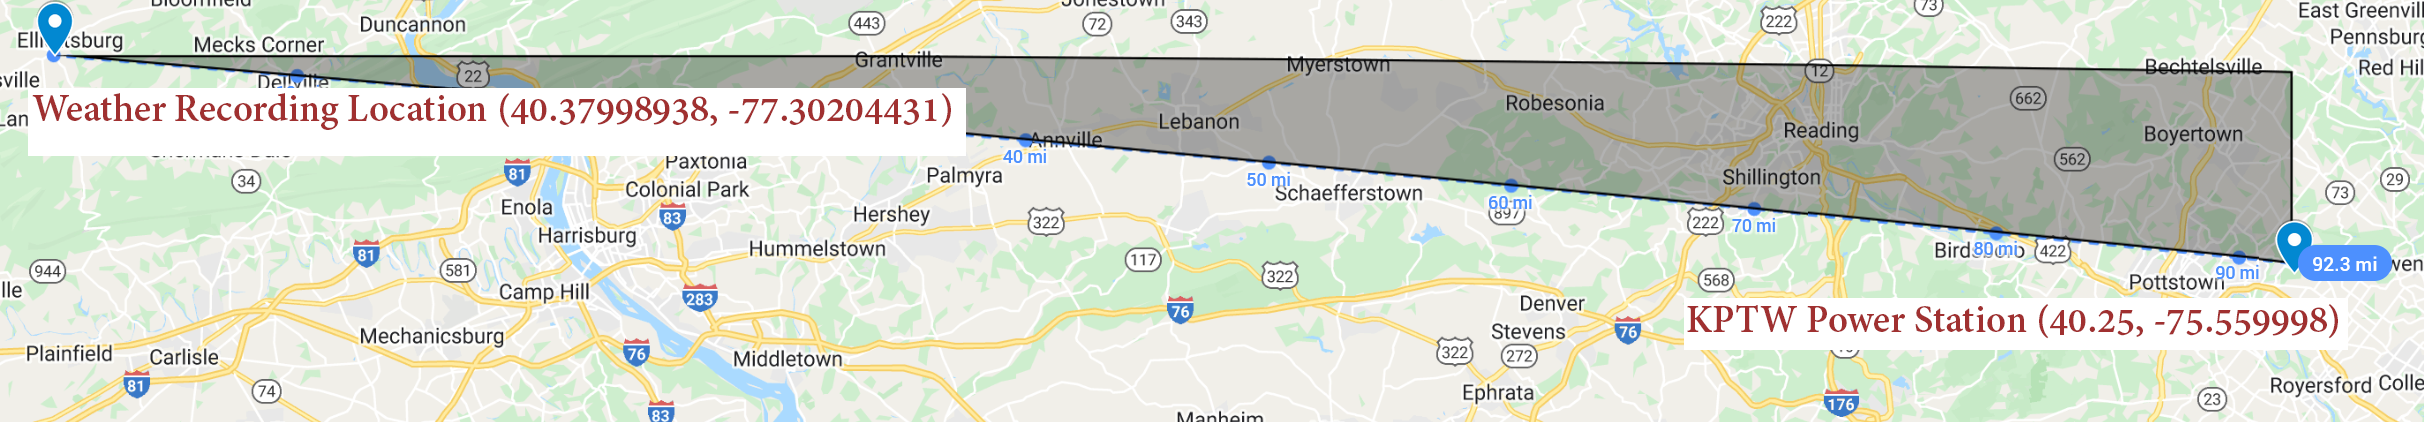

In [18]:
Image('/content/google_kptw.PNG.png')

# **Adding Weather Data with Meteostat**

| **Parameter**  | **Description**  | **Type**  |
|---|---|---|
| tavg  | The average air temperature in °C  |  Float |
|  tmin | The minimum air temperature in °C  |  Float |
| tmax  | The maximum air temperature in °C  | Float  |
| prcp  | The daily precipitation total in mm  |  Float |
| snow  | The maximum snow depth in mm  |  Integer |
| wdir  | The average wind direction in degrees (°)  | Integer  |
| wspd  | The average wind speed in km/h  | Float  |
| wpgt  | The peak wind gust in km/h  | Float  |
| pres  | The average sea-level air pressure in hPa  | Float  |
|  tsun |  The daily sunshine total in minutes (m) | Integer  |

 	 	 	 	 	 	 	 	 	

<sup>Source: [Daily Data Documentation](https://dev.meteostat.net/api/point/daily.html#endpoint) from meteostat.net<sup/>

In [19]:
df_outage.dtypes

OUTAGE_PK                           int64
ORDER_ID                            int64
INCIDENT_ID                         int64
JOB_NUMBER                         object
OUTAGE_TYPE                        object
INCIDENT_STATUS                    object
GRID_NUMBER                        object
GRID_POLT_AREA_FK                   int64
TROUBLE_TIME                       object
TROUBLE_TIME_FK                     int64
TROUBLE_TIME_CLOCK_FK               int64
TROUBLE_YR_MONTH                   object
LOCATION_DESC                      object
CREATION_TIME                      object
CREATION_TIME_CLOCK_FK              int64
ASSIGNED_TIME                      object
RESTORED_TIME                      object
RESTORED_TIME_FK                    int64
RESTORED_TIME_CLOCK_FK              int64
CLOSURE_TIME                       object
CLOSURE_TIME_FK                     int64
CLOSURE_TIME_CLOCK_FK               int64
PRIORITY                          float64
MIN_X                             

In [20]:
df_outage.loc[:,'TROUBLE_TIME'] = pd.to_datetime(df_outage['TROUBLE_TIME']) 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
weather_data = []
weather_data.append(['tavg', 	'tmin', 	'tmax', 	'prcp', 	'snow', 	'wdir', 	'wspd', 	'wpgt', 	'pres', 	'tsun'])

for date, weather_location in zip(df_outage['TROUBLE_TIME'], df_outage['LATITUDE & LONGITUDE']):
  meteostat_loc = Point(weather_location[0],weather_location[1])
  data = Daily(meteostat_loc, date, date)
  #fetch the data from meteostat's API
  data = data.fetch()
  data = data.to_numpy()

  if len(data) == 0:
    #for locations/dates where there's no data create a NumPy area of null values
    weather_data.append(np.array([np.nan]*10))
  else:
    weather_data.append(data[0])

In [22]:
df_weather_data = pd.DataFrame(weather_data[1:],columns=weather_data[0])

In [23]:
df_outage.reset_index(inplace=True,drop = True)
df_outage_and_weather = pd.concat([df_outage, df_weather_data], axis=1)

In [24]:
df_outage_and_weather

OUTAGE_PK  ORDER_ID  INCIDENT_ID JOB_NUMBER OUTAGE_TYPE INCIDENT_STATUS  \
0       1219519   3903568      3996610  4002534-1          NL        Restored   
1       1219740   3903061      3996049  4002027-1          NL        Restored   
2       1219815   3903263      3996399  4002229-1          NL        Restored   
3       1215540   3898578      3991440  3997543-1          NL        Restored   
4       1215617   3898626      3991503  3997591-1          NL        Restored   
...         ...       ...          ...        ...         ...             ...   
5136     829297   1228346      1304618  1327313-1          NL        Restored   
5137     828515   1227044      1303238  1326011-1          NL        Restored   
5138     828516   1227060      1303255  1326027-1          NL        Restored   
5139     829321   1229202      1305596  1328169-1          NL        Restored   
5140     829322   1229239      1305634  1328206-1          NL        Restored   

      GRID_NUMBER  GRID_POLT_AREA_FK TROUBLE_TIME  TROUBLE_TIME_FK  \
0     12480S38159            7893233   2017-10-09         20171009   
1     24368S32675            7163075   2017-10-09         20171009   
2     60953S50907            6706782   2017-10-09         20171009   
3     61462N26393            6911857   2017-09-28         20170928   
4     63570S44243            6742719   2017-09-28         20170928   
...           ...                ...          ...              ...   
5136  49163S36319            7272638   2014-07-02         20140702   
5137  18068N38326            7536185   2014-07-01         20140701   
5138  66787N42554            6932052   2014-07-01         20140701   
5139  54174N43124            7520101   2014-07-03         20140703   
5140  45046S37779            7846749   2014-07-02         20140702   

      TROUBLE_TIME_CLOCK_FK TROUBLE_YR_MONTH  \
0                     57459          2017-10   
1                     36821          2017-10   
2                     42901          2017-10   
3                     36449          2017-09   
4                     42222          2017-09   
...                     ...              ...   
5136                  53998          2014-07   
5137                  26325          2014-07   
5138                  29276          2014-07   
5139                  20989          2014-07   
5140                  62585          2014-07   

                              LOCATION_DESC CREATION_TIME  \
0              12480S38159 - GREEN PARK SUB      9-Oct-17   
1                               24368S32675      9-Oct-17   
2       60953S50907 - NEFF-LAURYS RD-E T706      9-Oct-17   
3            61462N26393 - S OF TRACHSVILLE     28-Sep-17   
4     63570S44243 - KOZY KOR LA W LIMEPT PK     28-Sep-17   
...                                     ...           ...   
5136                            49163S36319      2-Jul-14   
5137                   18068N38326 - SR 654      1-Jul-14   
5138              66787N42554-0 OFF MAIN ST      1-Jul-14   
5139                            54174N43124      3-Jul-14   
5140                            45046S37779      3-Jul-14   

      CREATION_TIME_CLOCK_FK ASSIGNED_TIME RESTORED_TIME  RESTORED_TIME_FK  \
0                      57459           NaN      9-Oct-17          20171009   
1                      37167      9-Oct-17      9-Oct-17          20171009   
2                      42904      9-Oct-17      9-Oct-17          20171009   
3                      36451     28-Sep-17     28-Sep-17          20170928   
4                      42226     28-Sep-17     28-Sep-17          20170928   
...                      ...           ...           ...               ...   
5136                   54002      3-Jul-14      3-Jul-14          20140703   
5137                   26329      1-Jul-14      1-Jul-14          20140701   
5138                   29279      1-Jul-14      1-Jul-14          20140701   
5139                   20995      3-Jul-14      3-Jul-14          20140703   
5140                   2

# **References and Additional Learning**

## **Websites**

- **[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) from Wikipedia.org**

- **[Google Maps](https://maps.google.com/)**

- **[Merge, join, concatenate and compare using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) from pandas documentation**

- **[Daily Data Documentation](https://dev.meteostat.net/api/point/daily.html#endpoint) from meteostat.net**

# **Connect**
- **Feel free to connect with Adrian on [YouTube](https://www.youtube.com/channel/UCPuDxI3xb_ryUUMfkm0jsRA), [LinkedIn](https://www.linkedin.com/in/adrian-dolinay-frm-96a289106/), [Twitter](https://twitter.com/DolinayG) and [GitHub](https://github.com/ad17171717). Happy coding!**